In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [ ]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    attn_state_path = '/content/drive/MyDrive/attn.pth'
    lstm_state_path = '/content/drive/MyDrive/lstm.pth'
    cnn_state_path = '/content/drive/MyDrive/cnn.pth'


    cnn_logs = '/content/drive/MyDrive/cnn.csv'

    train_csv_path = '/content/drive/MyDrive/mitbih_with_syntetic_train.csv'
    test_csv_path = '/content/drive/MyDrive/mitbih_with_syntetic_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [ ]:
df_ptbdb = pd.read_csv('/content/drive/MyDrive/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv')
df_ptbdb


,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10501,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_mitbih_train = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('/content/drive/MyDrive/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'


In [ ]:
df_mitbih = pd.read_csv(config.csv_path)
df_mitbih['label'].value_counts()

,count
label,
Normal,90589
Fusion of paced and normal,8039
Premature ventricular contraction,7236
Artial Premature,2779
Fusion of ventricular and normal,803


<ipython-input-9-4048187147>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
<ipython-input-9-4048187147>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15);


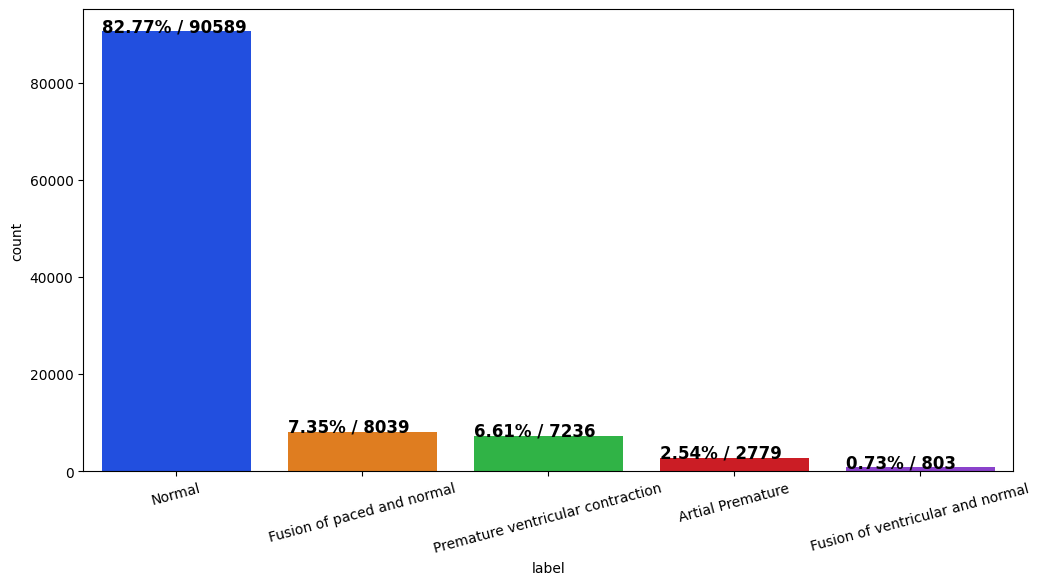

In [ ]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):

    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')

plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
config.csv_path = '/content/drive/MyDrive/mitbih_with_syntetic.csv'
df_mitbih_new = pd.read_csv(config.csv_path)


In [ ]:
%%time
signals = [' '.join(df_mitbih.iloc[i, :-1].apply(str).values) for i in range(df_mitbih.shape[0])]
y = df_mitbih.iloc[:, -1].values.tolist()
print(len(signals), len(y))

print(f'data has {len(set([sig for line in signals for sig in line.split()]))} out of 16 372 411 unique values.')


109446 109446
data has 279149 out of 16 372 411 unique values.
CPU times: user 1min 4s, sys: 5.02 s, total: 1min 9s
Wall time: 1min 13s


In [ ]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [ ]:
def get_dataloader(phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

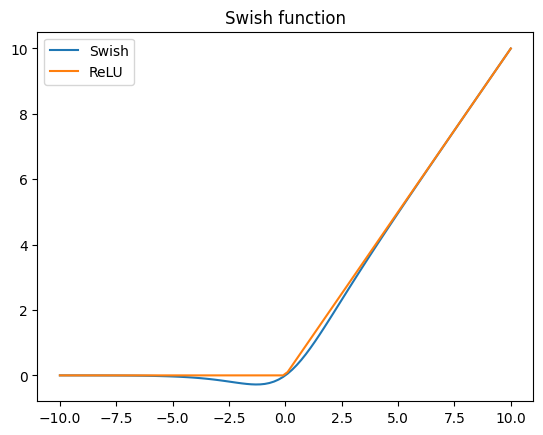

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()


In [ ]:
class ConvNormPool(nn.Module):
    """Khai báo cấu trúc hàm"""
     def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()

        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)

        self.pool = nn.MaxPool1d(kernel_size=2)
    "thực hiện thuật toán"
    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))

        x = self.pool(x)
        return x

IndentationError: unexpected indent (<ipython-input-40-df78c4e9a827>, line 3)

In [ ]:
class CNN(nn.Module):
    """Định nghĩa cấu trúc mạng CNN"""

    def __init__(
        self,
        input_size=1,       # Kích thước đầu vào (số kênh)
        hid_size=256,       # Kích thước lớp ẩn
        kernel_size=5,      # Kích thước kernel cho các lớp Conv
        num_classes=5,      # Số lớp trong bài toán phân loại
    ):
        super().__init__()

        # Các lớp ConvNormPool (giả sử là lớp đã được định nghĩa trước đó)
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size // 2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size // 2,
            hidden_size=hid_size // 4,
            kernel_size=kernel_size,
        )

        # Lớp avgpool: Dùng AdaptiveAvgPool1d để giảm chiều dữ liệu
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Lớp fully connected (fc) để phân loại
        self.fc = nn.Linear(in_features=hid_size // 4, out_features=num_classes)

    def forward(self, x):
        """Thuật toán tính toán thông qua các lớp trong CNN"""

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Áp dụng Adaptive Average Pooling
        x = self.avgpool(x)

        # Chuyển đổi tensor từ dạng [B, C, 1] về [B, C] cho lớp fully connected
        x = x.view(x.size(0), -1)  # Giữ lại kích thước batch, giảm chiều còn lại

        # Lớp fully connected
        x = self.fc(x)

        return x

Giả sử kết quả của bạn là:


logits = [2.0, 1.0, -1.0, 0.5, 3.0]
Sau khi áp dụng Softmax, bạn có thể có kết quả xác suất như sau:


softmax_output = [0.45, 0.15, 0.02, 0.07, 0.31]

In [ ]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))

    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)

        self._compute_cm(x, y)

    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1

    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0

    def get_metrics(self):
        return self.metrics

    def get_confusion_matrix(self):
        return self.confusion

In [ ]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()

    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()

        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)

            output = self.net(data)
            loss = self.criterion(output, target)

            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            meter.update(output, target, loss.item())

        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()

        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)

        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()

        return loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
            #clear_output()


In [ ]:

model = CNN(num_classes=5, hid_size=128)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train mode | time: 15:38:44


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.nda

loss: 0.09401209273234726, accuracy: 0.9754016419398746, f1: 0.9165019587956205, precision: 0.9092688025917904, recall: 0.9576654399169383


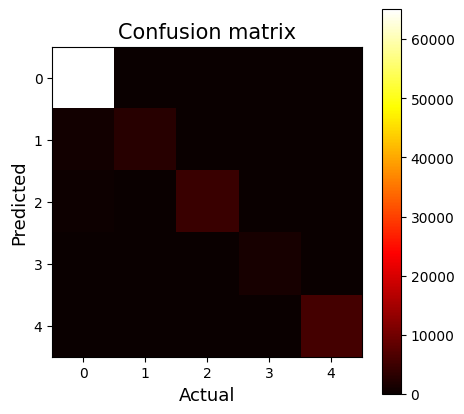

val mode | time: 15:51:23


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.07687641984472672, accuracy: 0.985069444444445, f1: 0.9422899453269518, precision: 0.9344487718343193, recall: 0.9719661013028165


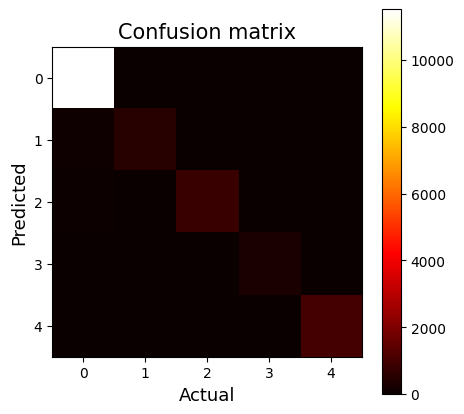


New checkpoint

train mode | time: 15:52:08


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.0673503671682157, accuracy: 0.9822402507714505, f1: 0.9360077039747895, precision: 0.9310487951299858, recall: 0.9685882734763577


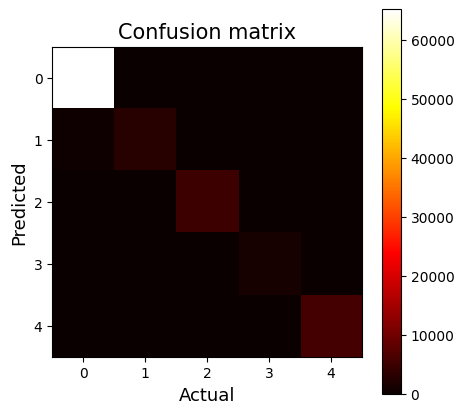

val mode | time: 16:04:50


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.06452651254677524, accuracy: 0.9877302631578946, f1: 0.9521239826657723, precision: 0.9413685490766855, recall: 0.9816049353366219


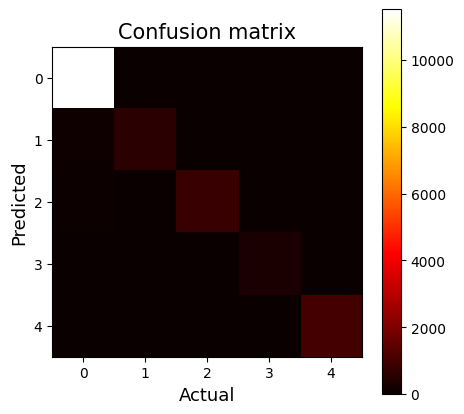

train mode | time: 16:05:36


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.04984270311413815, accuracy: 0.9864326885502159, f1: 0.9494425682268646, precision: 0.9460299759278411, recall: 0.9744566822963278


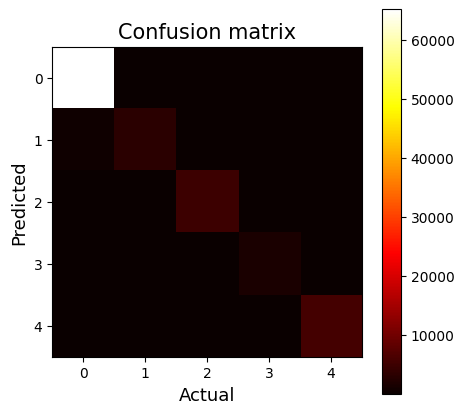

val mode | time: 16:18:08


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.05716719953576103, accuracy: 0.990299707602339, f1: 0.9585609444020129, precision: 0.9505725832331087, recall: 0.9822115679482952


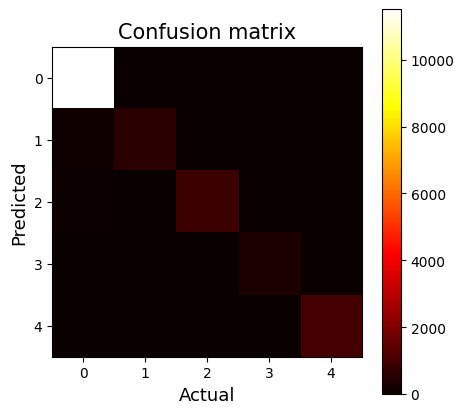


New checkpoint

train mode | time: 16:18:50


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.03530605079126867, accuracy: 0.9908411488862859, f1: 0.9645980334547506, precision: 0.9616377446239358, recall: 0.982843260169286


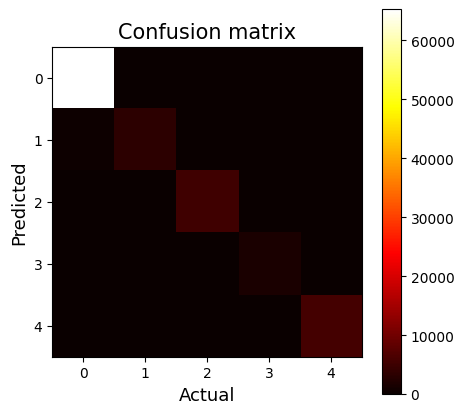

val mode | time: 16:31:20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.044635897668388984, accuracy: 0.9938413742690054, f1: 0.9686021468014533, precision: 0.9667452373950571, recall: 0.9812974402129359


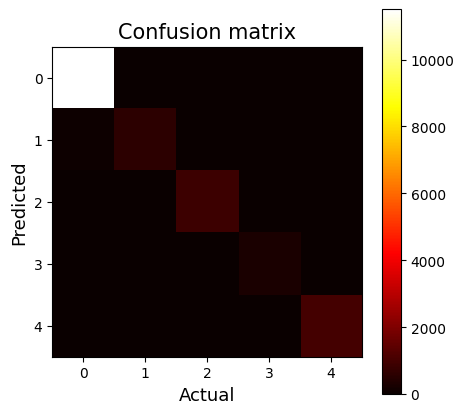

train mode | time: 16:32:04


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.02483204856980592, accuracy: 0.9939185228604942, f1: 0.9746258496743027, precision: 0.9723723904081492, recall: 0.9878865783624451


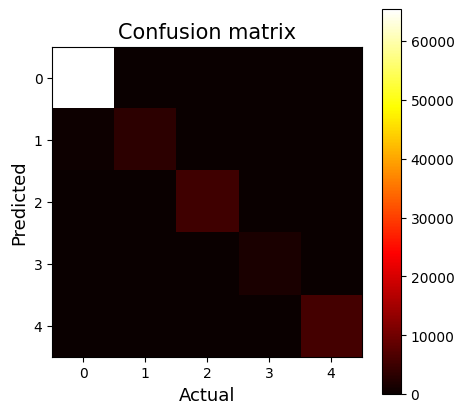

val mode | time: 16:44:43


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

loss: 0.0368424259351256, accuracy: 0.9953691520467836, f1: 0.9704304896273229, precision: 0.9671996967609071, recall: 0.9876284563159601


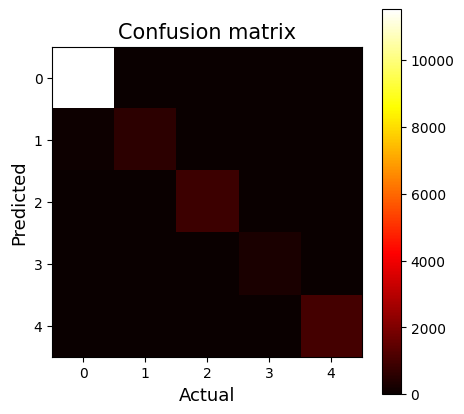

In [ ]:
trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=5)#100)
trainer.run()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal = torch.FloatTensor([signal.values])
<ipython-input-11-e5acc32f7d01>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before con

                                   precision    recall  f1-score       support
Normal                              0.990882  0.997230  0.994046  11551.000000
Artial Premature                    0.970684  0.903030  0.935636    660.000000
Premature ventricular contraction   0.968547  0.967497  0.968022    923.000000
Fusion of ventricular and normal    0.989091  0.912752  0.949389    298.000000
Fusion of paced and normal          0.994123  0.990244  0.992180   1025.000000
accuracy                            0.988794  0.988794  0.988794      0.988794
macro avg                           0.982665  0.954151  0.967854  14457.000000
weighted avg                        0.988727  0.988794  0.988665  14457.000000


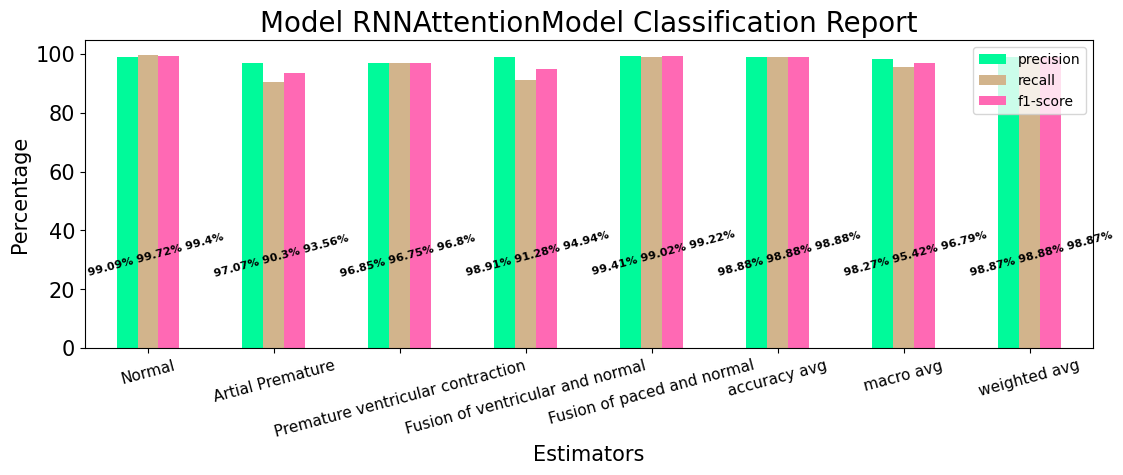

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển mô hình sang device (GPU hoặc CPU)
model.to(device)

# Tạo DataLoader cho validation
val_loader = get_dataloader(phase='val', batch_size=32)  # Gọi hàm get_dataloader cho validation

# Đặt mô hình về chế độ đánh giá
model.eval()  # Chuyển mô hình sang chế độ đánh giá (evaluation mode)

y_true = []  # Nhãn thực tế
y_pred = []  # Nhãn dự đoán

# Dự đoán trên tập kiểm tra
with torch.no_grad():  # Tắt tính toán gradient (vì không cần backpropagation)
    for inputs, labels in val_loader:
        # Đảm bảo inputs và labels là tensor và chuyển sang device (GPU hoặc CPU)
        inputs = inputs.to(device)  # Chuyển inputs sang device
        labels = labels.to(device)  # Chuyển labels sang device

        outputs = model(inputs)  # Mô hình đưa ra dự đoán
        _, predicted = torch.max(outputs, 1)  # Lấy chỉ số lớp có xác suất cao nhất

        y_true.extend(labels.cpu().numpy())  # Thêm nhãn thực tế vào y_true
        y_pred.extend(predicted.cpu().numpy())  # Thêm nhãn dự đoán vào y_pred

# Tính toán báo cáo phân loại
report = classification_report(y_true, y_pred, target_names=list(id_to_label.values()), output_dict=True)

# Chuyển đổi báo cáo thành DataFrame để dễ dàng vẽ
report_df = pd.DataFrame(report).transpose()

# Hiển thị báo cáo phân loại
print(report_df)

# Vẽ biểu đồ nếu cần
import matplotlib.pyplot as plt

colors = ['#00FA9A', '#D2B48C', '#FF69B4']  # Màu sắc cho biểu đồ
report_plot = report_df.apply(lambda x: x * 100)  # Chuyển báo cáo thành phần trăm
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar', figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values()) + ["accuracy avg", "macro avg", "weighted avg"],
    rotation=15, fontsize=11
)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("Model RNNAttentionModel Classification Report", fontsize=20)

# Annotate tỷ lệ trên mỗi cột của biểu đồ
for percentage, p in zip(
    report_df[['precision', 'recall', 'f1-score']].values,
    ax.patches
):
    percentage = " ".join([str(round(i * 100, 2)) + "%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')

# Lưu biểu đồ dưới dạng ảnh PNG và SVG
fig = plt.gcf()
fig.savefig("model_report.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("model_report.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
print(trainer.train_df_logs.columns)
print(trainer.val_df_logs.columns)

Index(['loss', 'accuracy', 'f1', 'precision', 'recall'], dtype='object')
Index(['loss', 'accuracy', 'f1', 'precision', 'recall'], dtype='object')


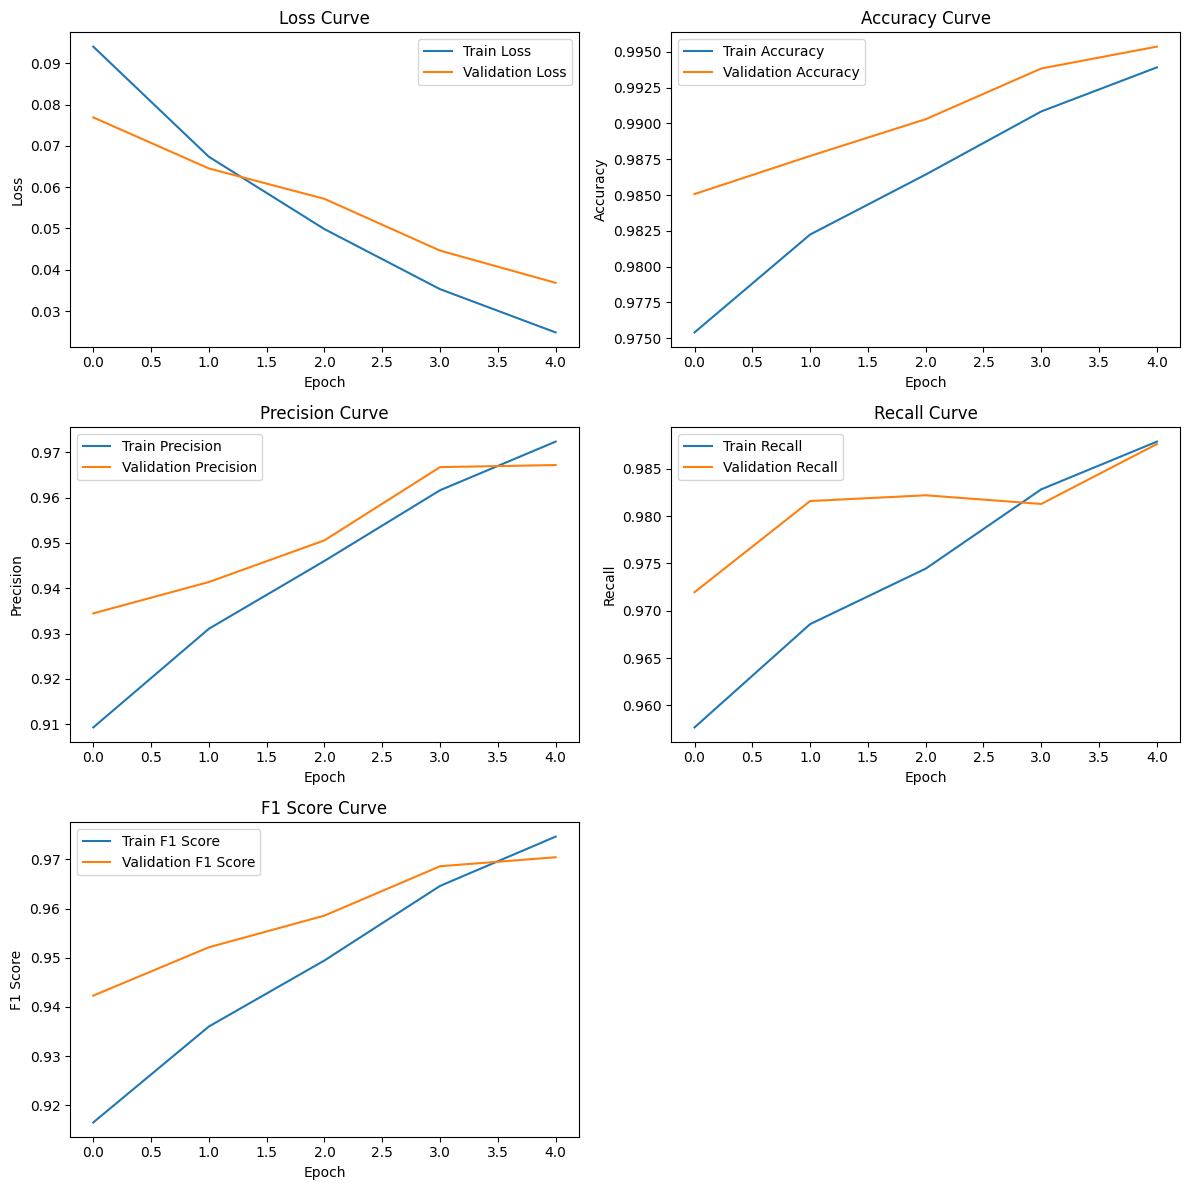

In [ ]:
import matplotlib.pyplot as plt

# Sau khi huấn luyện xong, bạn có thể gọi hàm vẽ biểu đồ
def plot_training_progress(trainer):
    # Lấy các giá trị từ DataFrame
    train_losses = trainer.train_df_logs['loss'].values
    val_losses = trainer.val_df_logs['loss'].values
    train_accuracies = trainer.train_df_logs['accuracy'].values
    val_accuracies = trainer.val_df_logs['accuracy'].values
    train_precisions = trainer.train_df_logs['precision'].values
    val_precisions = trainer.val_df_logs['precision'].values
    train_recalls = trainer.train_df_logs['recall'].values
    val_recalls = trainer.val_df_logs['recall'].values
    train_f1_scores = trainer.train_df_logs['f1'].values
    val_f1_scores = trainer.val_df_logs['f1'].values

    # Tạo figure và các subplots
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.ravel()  # Lấy array của axes

    # Loss Curve
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy Curve
    axes[1].plot(train_accuracies, label='Train Accuracy')
    axes[1].plot(val_accuracies, label='Validation Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Precision Curve
    axes[2].plot(train_precisions, label='Train Precision')
    axes[2].plot(val_precisions, label='Validation Precision')
    axes[2].set_title('Precision Curve')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Precision')
    axes[2].legend()

    # Recall Curve
    axes[3].plot(train_recalls, label='Train Recall')
    axes[3].plot(val_recalls, label='Validation Recall')
    axes[3].set_title('Recall Curve')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('Recall')
    axes[3].legend()

    # F1 Score Curve
    axes[4].plot(train_f1_scores, label='Train F1 Score')
    axes[4].plot(val_f1_scores, label='Validation F1 Score')
    axes[4].set_title('F1 Score Curve')
    axes[4].set_xlabel('Epoch')
    axes[4].set_ylabel('F1 Score')
    axes[4].legend()

    # Tắt subplot thứ 6 vì chúng ta chỉ vẽ 5 biểu đồ
    fig.delaxes(axes[5])

    # Tối ưu layout để không bị chồng lấn
    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ các biểu đồ
plot_training_progress(trainer)

<ipython-input-41-e79a50824af4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(config.cnn_state_path,


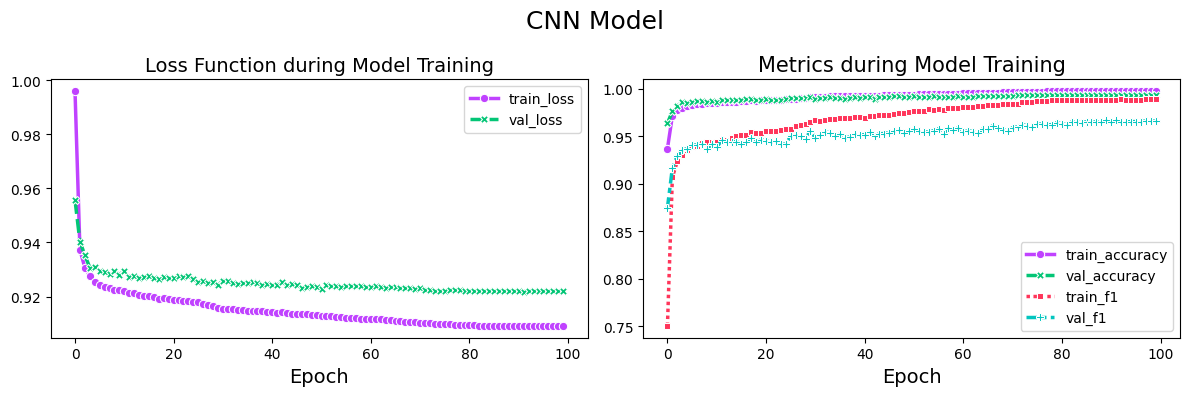

In [ ]:
lstm_model = RNNModel(1, 64, 'lstm', True).to(config.device)
lstm_model.load_state_dict(
    torch.load(config.lstm_state_path,
               map_location=config.device)
);
lstm_model.eval();
logs = pd.read_csv(config.lstm_logs)

In [ ]:
attn_model = RNNAttentionModel(1, 64, 'lstm', False).to(config.device)
attn_model.load_state_dict(
    torch.load(config.attn_state_path,
               map_location=config.device)
);
attn_model.eval();
logs = pd.read_csv(config.attn_logs)


In [ ]:
test_df = pd.read_csv(config.test_csv_path)
print(test_df.shape)
test_dataset = ECGDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=96, num_workers=0, shuffle=False)


(17008, 189)


In [ ]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)

            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)

            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls


In [ ]:
models = [cnn_model, lstm_model, attn_model]


In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[0])
y_pred.shape, y_true.shape

<ipython-input-13-807127495>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal = torch.FloatTensor([signal.values])


((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()


NameError: name 'fig' is not defined

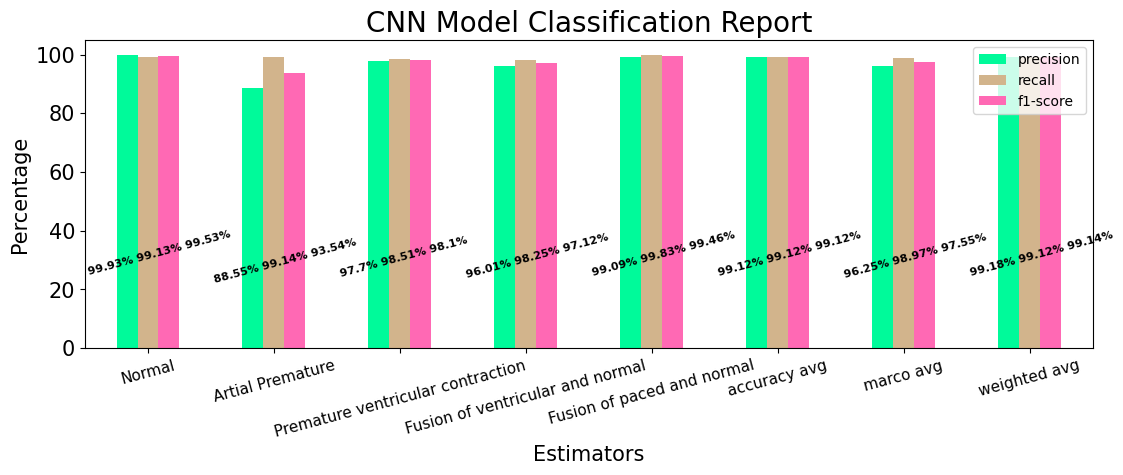

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):

    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
y_true_all, y_pred_all = [], []

model.eval()
with torch.no_grad():
    for data, target in trainer.dataloaders['val']:
        data = data.to(config.device)
        target = target.to(config.device).long()

        output = model(data)
        _, preds = torch.max(output, 1)

        y_true_all.extend(target.cpu().numpy())
        y_pred_all.extend(preds.cpu().numpy())

# 🟩 Bước 2: Tạo classification report dạng pandas DataFrame
target_names = [id_to_label[i] for i in sorted(id_to_label.keys())]
report = classification_report(
    y_true_all, y_pred_all,
    target_names=target_names,
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report).transpose()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


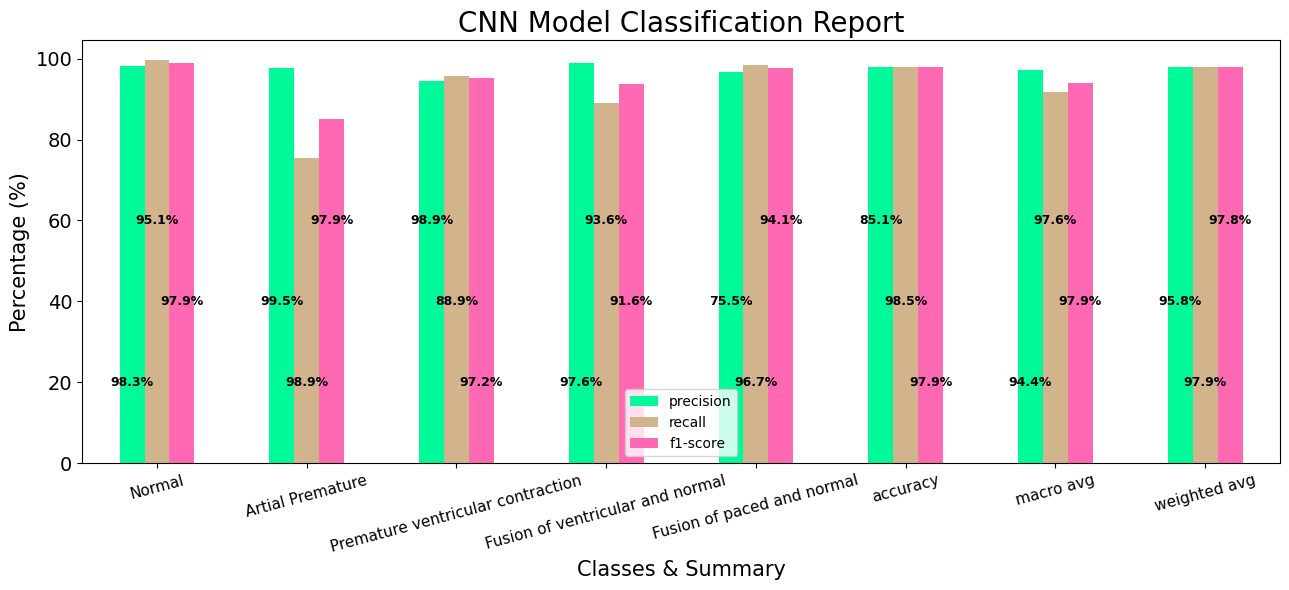

In [ ]:
report_df = pd.DataFrame(report).transpose()

# 🟦 Chuyển sang phần trăm
report_plot = report_df[["precision", "recall", "f1-score"]].apply(lambda x: x * 100)

# 🟦 Đảm bảo các dòng được sắp đúng thứ tự mong muốn
desired_order = list(id_to_label.values()) + ["accuracy", "macro avg", "weighted avg"]
report_plot = report_plot.loc[desired_order]

# 🟦 Màu sắc
colors = ['#00FA9A', '#D2B48C', '#FF69B4']

# 🟦 Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(13, 6))
report_plot.plot(kind='bar', ax=ax, color=colors, legend=True, fontsize=14)

# Gán nhãn trục và tiêu đề
ax.set_xlabel("Classes & Summary", fontsize=15)
ax.set_ylabel("Percentage (%)", fontsize=15)
ax.set_title("CNN Model Classification Report", fontsize=20)

# Gán nhãn X đúng thứ tự
ax.set_xticklabels(desired_order, rotation=15, fontsize=11)

# 🟦 Annotate giá trị trên cột
fixed_heights = [20, 40, 60]  # Precision, Recall, F1
patch_idx = 0

for i in range(len(report_plot)):  # duyệt từng nhãn (label/class)
    for j in range(3):  # precision, recall, f1-score
        p = ax.patches[patch_idx]
        value = report_plot.iloc[i, j]

        ax.annotate(f'{value:.1f}%',
                    (p.get_x() + p.get_width() / 2., fixed_heights[j]),  # fixed Y
                    ha='center', va='center',
                    fontsize=9, fontweight='bold', color='black')

        patch_idx += 1

# 🟦 Lưu ảnh
fig.tight_layout()
fig.savefig("cnn_report.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn_report.svg", format="svg", pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
y_pred, y_true = make_test_stage(test_dataloader, models[1])
y_pred.shape, y_true.shape

((17008,), (17008,))

In [ ]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()


NameError: name 'pd' is not defined